In [8]:
import math
import pandas as pd
import matplotlib.pyplot as plt

from rouge import Rouge

from datasets import load_dataset
from transformers import BartTokenizer, BartForConditionalGeneration

In [9]:
dataset = load_dataset('cnn_dailymail', '3.0.0')
data = dataset['test']
data_df = pd.DataFrame(data)

Found cached dataset cnn_dailymail (C:/Users/vijay/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
data_df['article_length'] = data_df['article'].apply(lambda x: len(x))

In [11]:
data_df['summary_length'] = data_df['article'].apply(lambda x: math.ceil(len(x)/10))

In [12]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

In [13]:
def get_summary(row):
    
    input_text = row['article']
    max_length = row['summary_length']
    
    if max_length > 1024:
        max_length = 1024
    elif max_length < 56:
        max_length = 56
    
    inputs = tokenizer(input_text, truncation=True, padding="longest", max_length=1024, return_tensors="pt")
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=max_length, early_stopping=True)
    
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [14]:
data_df['summary'] = data_df.apply(lambda row: get_summary(row), axis=1)

In [15]:
rouge = Rouge()

data_df['rouge_scores'] = data_df.apply(lambda row: rouge.get_scores(row['summary'], row['highlights']), axis=1)

In [16]:
rouge_scores = data_df['rouge_scores']

rouge_1 = {'r': 0, 'p': 0, 'f': 0}
rouge_2 = {'r': 0, 'p': 0, 'f': 0}
rouge_l = {'r': 0, 'p': 0, 'f': 0}

for scores in rouge_scores:
    rouge_1_scores = scores[0]['rouge-1']
    rouge_2_scores = scores[0]['rouge-2']
    rouge_l_scores = scores[0]['rouge-l']

    rouge_1['r'] += rouge_1_scores['r']
    rouge_1['p'] += rouge_1_scores['p']
    rouge_1['f'] += rouge_1_scores['f']

    rouge_2['r'] += rouge_2_scores['r']
    rouge_2['p'] += rouge_2_scores['p']
    rouge_2['f'] += rouge_2_scores['f']

    rouge_l['r'] += rouge_l_scores['r']
    rouge_l['p'] += rouge_l_scores['p']
    rouge_l['f'] += rouge_l_scores['f']

num_rows = len(rouge_scores)

rouge_1_avg = {'recall': rouge_1['r'] / num_rows, 'precision': rouge_1['p'] / num_rows, 'f1-score': rouge_1['f'] / num_rows}
rouge_2_avg = {'recall': rouge_2['r'] / num_rows, 'precision': rouge_2['p'] / num_rows, 'f1-score': rouge_2['f'] / num_rows}
rouge_l_avg = {'recall': rouge_l['r'] / num_rows, 'precision': rouge_l['p'] / num_rows, 'f1-score': rouge_l['f'] / num_rows}

average_scores = pd.DataFrame({'ROUGE-1': rouge_1_avg, 'ROUGE-2': rouge_2_avg, 'ROUGE-L': rouge_l_avg})

average_scores.to_csv('bart_rouge.csv', index=True)

average_scores

,ROUGE-1,ROUGE-2,ROUGE-L
recall,0.455617,0.212088,0.428901
precision,0.370296,0.166839,0.348591
f1-score,0.400851,0.182211,0.377345


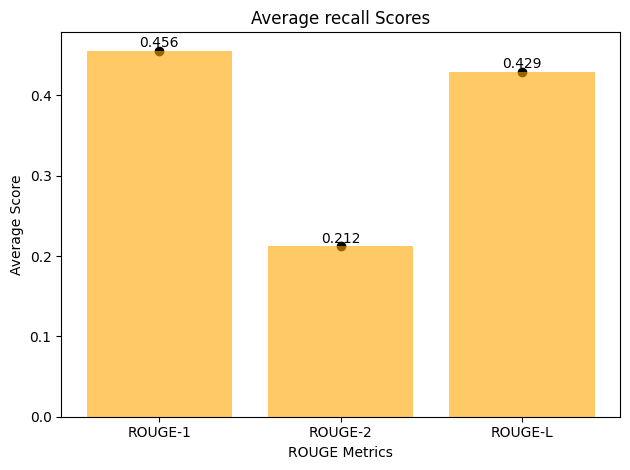

In [17]:
x_values = average_scores.columns
y_values = average_scores.loc['recall']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average recall Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

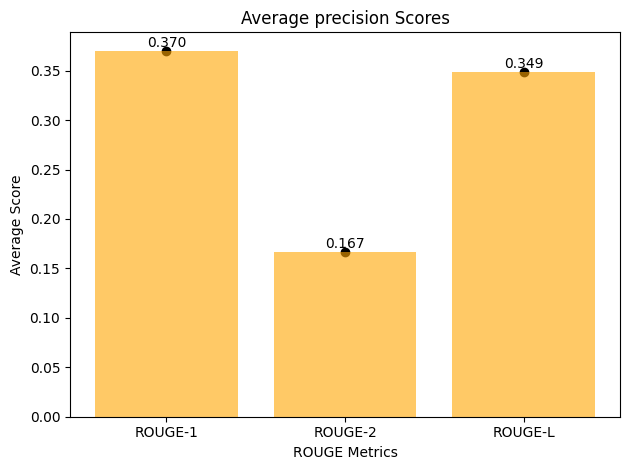

In [18]:
x_values = average_scores.columns
y_values = average_scores.loc['precision']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average precision Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

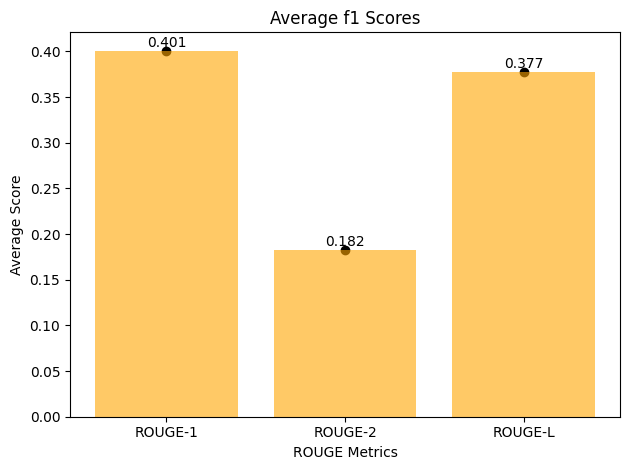

In [19]:
x_values = average_scores.columns
y_values = average_scores.loc['f1-score']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average f1 Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

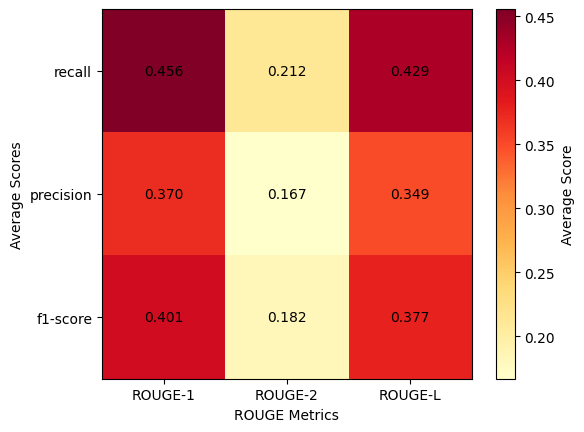

In [20]:
plt.imshow(average_scores, cmap='YlOrRd')

plt.xticks(range(len(average_scores.columns)), average_scores.columns)
plt.yticks(range(len(average_scores.index)), average_scores.index)
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average Scores')

for i in range(len(average_scores.index)):
    for j in range(len(average_scores.columns)):
        plt.text(j, i, f'{average_scores.iloc[i, j]:.3f}', ha='center', va='center', color='black')

plt.colorbar(label='Average Score')

plt.show()

In [21]:
data_df.to_csv('bart.csv', index=True)